# **ODIN Project** 

In [82]:
import boto3 
import pandas as pd 
import pymysql
import pymssql 
import os 
import json 
import warnings 
import numpy as np 
import squarify as sq 

import matplotlib.pyplot as plt 
import seaborn as sns 
from typing import List, Dict 

warnings.filterwarnings('ignore')

## **Project Resources**

In [5]:
secrets = boto3.client('secretsmanager')
s3 = boto3.client('s3')
s3.download_file(Bucket=os.environ.get('TAX').split("/")[2], Key='/'.join(os.environ.get('TAX').split("/")[3:]), Filename="/tmp/fueltaxes.xlsx")

## **DB Auth** 

In [9]:
user1, passwd1, host1, db1, _ = list(json.loads(secrets.get_secret_value(SecretId=os.environ.get('MYSQL')).get('SecretString')).values())
con1: 'MYSQL' = pymysql.connect(user=user1, password=passwd1, db=db1, host=host1)
cursor1 = con1.cursor()

user2, passwd2, host2, db2 = list(json.loads(secrets.get_secret_value(SecretId=os.environ.get('MSSQL')).get('SecretString')).values())
con2: 'MSSQL' = pymssql.connect(user=user2, password=passwd2, database=db2, server=host2)
cursor2 = con2.cursor()


##  **Fuel Taxes**
Gasoline prices in the United States, a constant presence in our lives, are subject to various factors. Beyond the fundamental dynamics of supply and demand, the influence of taxation adds a complex layer to the composition of gasoline prices. This study embarks on a comprehensive exploration, delving into the multifaceted impact of state gasoline taxes on the cost of fuel. 

1. **State Gasoline Taxes**: State governments employ gasoline taxes to fund diverse projects, ranging from infrastructure endeavors to environmental conservation. The resultant disparity in tax rates shapes substantial price variations, affecting consumers and regional economies alike. Understanding the interplay between state budget priorities and gasoline taxes is vital for understanding the multifaceted nature of gasoline pricing. 
2. **Taxation as a Price Driver**: State governments have the power to impose gasoline taxes, both at the state and local levels. These taxes are calculated as a fixed amount per gallon or as a percentage of the retail price. As a result, the impact of taxation on gasoline prices is significant, often representing a substantial portion of the final cost consumers pay. The imposition of taxes contributes to the overall price structure and varies across states, leading to notable disparities in gasoline prices from one region to another. 
3. **Consumer Behavior and Economic Impact**: High gasoline taxes can alter consumer behavior, influencing travel patterns, vehicle purchases, and commuting choices. Regions with lower gasoline taxes may experience increased economic activity as consumers have more income, potentially leading to higher demand and pricing dynamics. On the other hand, areas with higher gasoline taxes might witness reduced consumption, impacting local economies. The interplay between consumer behavior, taxation, and pricing showcases the intricate balance taxation introduces to the gasoline market. 
4. **Environmental and Policy Consideration**: Some states leverage gasoline taxes as a policy tool to promote environmental sustainability. Higher gasoline taxes promote the adoption of fuel-efficient vehicles, public transportation, and cleaner energy alternatives. In this context, taxation influences prices and aligns with broader environmental and policy goals. The convergence of taxation and environmental considerations emphasizes the multifaceted nature of gasoline pricing.
   
Gasoline prices in the United States are a symphony of economic, regulatory, and societal factors. As a key player in this intricate composition, taxation introduces complex dynamics that ripple through the gasoline market. State gasoline taxes hold a multifaceted role beyond mere pricing, from funding critical infrastructure projects to shaping consumer behavior and advancing environmental objectives. A comprehensive comprehension of taxation's effects on gasoline prices is of utmost importance for individuals and policymakers, particularly as energy landscapes and policy priorities shift.

In [40]:
tax_df: 'DataFrame' = pd.read_excel("/tmp/fueltaxes.xlsx", sheet_name='January 2023')
tax_df = tax_df.iloc[7:63].drop(['Unnamed: 5', 'Unnamed: 10'], axis=1).rename(dict(map(lambda item: (item[0], item[1].strip()), tax_df.iloc[5].dropna().to_dict().items())), axis=1)
tax_df.index = np.arange(1, tax_df.shape[0] + 1)
tax_df = tax_df.replace({np.nan: 0.0})
tax_df.columns = [tax_df.columns[0].strip().lower()] +\
                 [ ('gasoline_%s' % (col)).strip().replace(' ', '_').lower() for col in tax_df.columns.tolist()[1:5] ] +\
                 [ ('diesel_%s' % (col)).strip().replace(' ', '_').lower() for col in tax_df.columns.tolist()[5:-1] ] +\
                 [tax_df.columns[-1].lower()]

states, gasoline_taxes = zip(*tax_df[tax_df.columns.tolist()[:5]].sort_values(by='gasoline_state_tax', ascending=True).set_index(tax_df.columns[0])['gasoline_state_tax'].to_dict().items())
all_states, state_fed_tax = zip(*tax_df[tax_df.columns.tolist()[:5]].sort_values(by='gasoline_state_&_federal', ascending=True).set_index(tax_df.columns[0])['gasoline_state_&_federal'].to_dict().items())

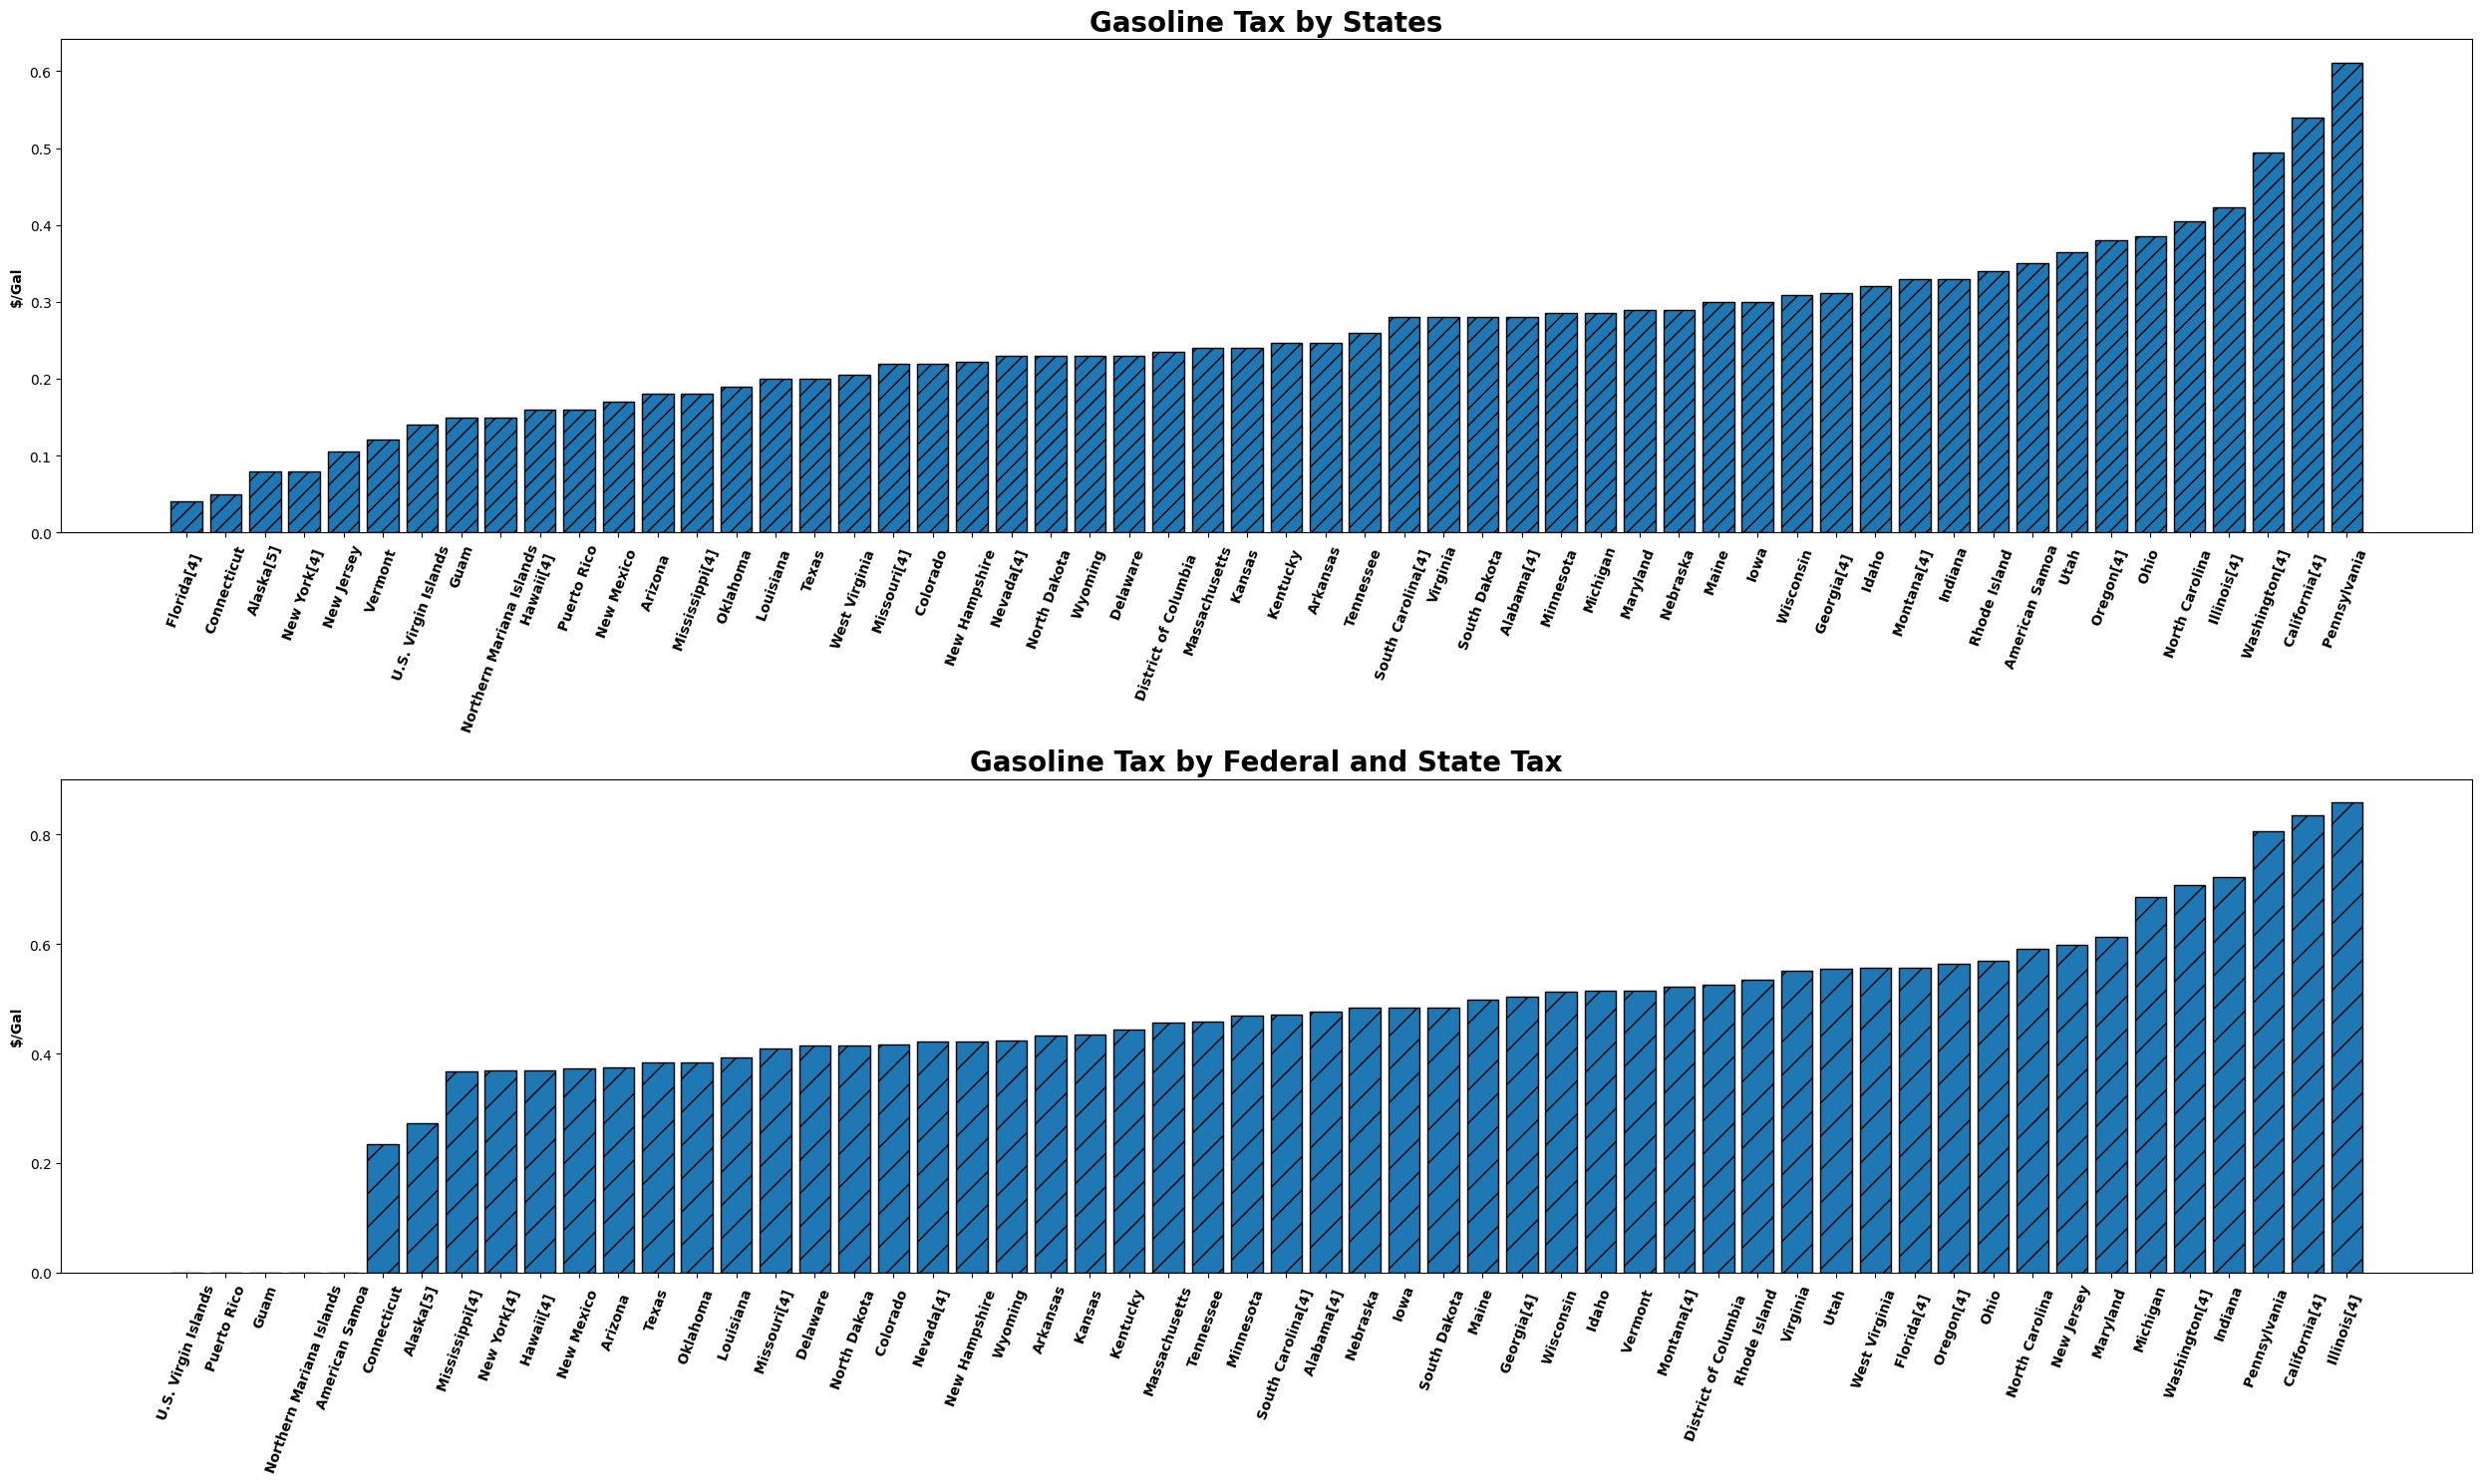

In [62]:
fig = plt.figure(figsize=(25,15) )
ax = fig.add_subplot(2,1,1)

# States 
ax.bar(x=list(states), height=list(gasoline_taxes), hatch="//", edgecolor='k')
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, fontweight='bold')
ax.set_title("Gasoline Tax by States", fontweight='bold', fontsize=20)
ax.set_ylabel("$/Gal", fontweight='bold')
plt.tight_layout() 

# Fed
ax = fig.add_subplot(2,1,2)
ax.bar(x=list(all_states), height=list(state_fed_tax), hatch="/", edgecolor='k') # color='red')
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, fontweight='bold')
ax.set_title("Gasoline Tax by Federal and State Tax", fontweight='bold', fontsize=20)
ax.set_ylabel("$/Gal", fontweight='bold')
plt.tight_layout() 

# **Gasoline Prices**

In [75]:
tbl_one: str = os.environ.get('tbl_one')
gasprices_df: 'DataFrame' = pd.read_sql(f"SELECT * FROM {tbl_one}",con=con1)
gasprices_df.head()

,index,gas_station,country,city,address,zip_code,state,regular_gas,midgrade_gas,premium_gas,price_unit,star_rating,latitude,longitude,timestamp,price,review,review_date,sentiment_score
0,0,1st Place Food Mart,US,Tillmans Corner,7000 Three Notch-Kroner Rd,36619,AL,1,1,1,dollars_per_gallon,4.1,30.589132,-88.205224,2023-05-21T12:10:31.001Z,2.82,love the cheaper gas.,2022-05-02T18:39:36.45Z,1.00000
1,1,Zippy Mart,US,Tillmans Corner,5936 Three Notch Rd,36619,AL,1,1,1,dollars_per_gallon,3.5,30.589263,-88.179333,2023-05-22T00:19:42.007Z,2.82,GOOD SERVICE,2017-01-23T09:40:24.88Z,0.57020
2,2,AAFES,US,Fort McClellan,1167 Fremont Rd,36205,AL,1,1,1,dollars_per_gallon,4.5,33.731789,-85.791281,2023-05-21T19:29:16.272Z,2.82,Military and family members only. They earned ...,2019-06-27T20:13:50.033Z,-0.19800
3,3,Sam's Club,US,Auburn,2335 Bent Creek Rd,36830,AL,1,0,1,dollars_per_gallon,4.6,32.608063,-85.428061,2023-05-22T02:21:02.515Z,2.84,Generally best price in town.,2022-11-02T19:20:19.87Z,0.81845
4,4,Sunoco,US,Leeds,7501 Parkway Dr,35094,AL,1,0,1,dollars_per_gallon,3.1,33.544691,-86.554397,2023-05-21T13:38:20.812Z,2.82,great service and amazing Race Fuels,2020-06-18T14:01:04.797Z,0.76800


In [ ]:
states, avg_price = zip(*gasprices_df.groupby('state')['price'].agg('mean').to_dict().items())

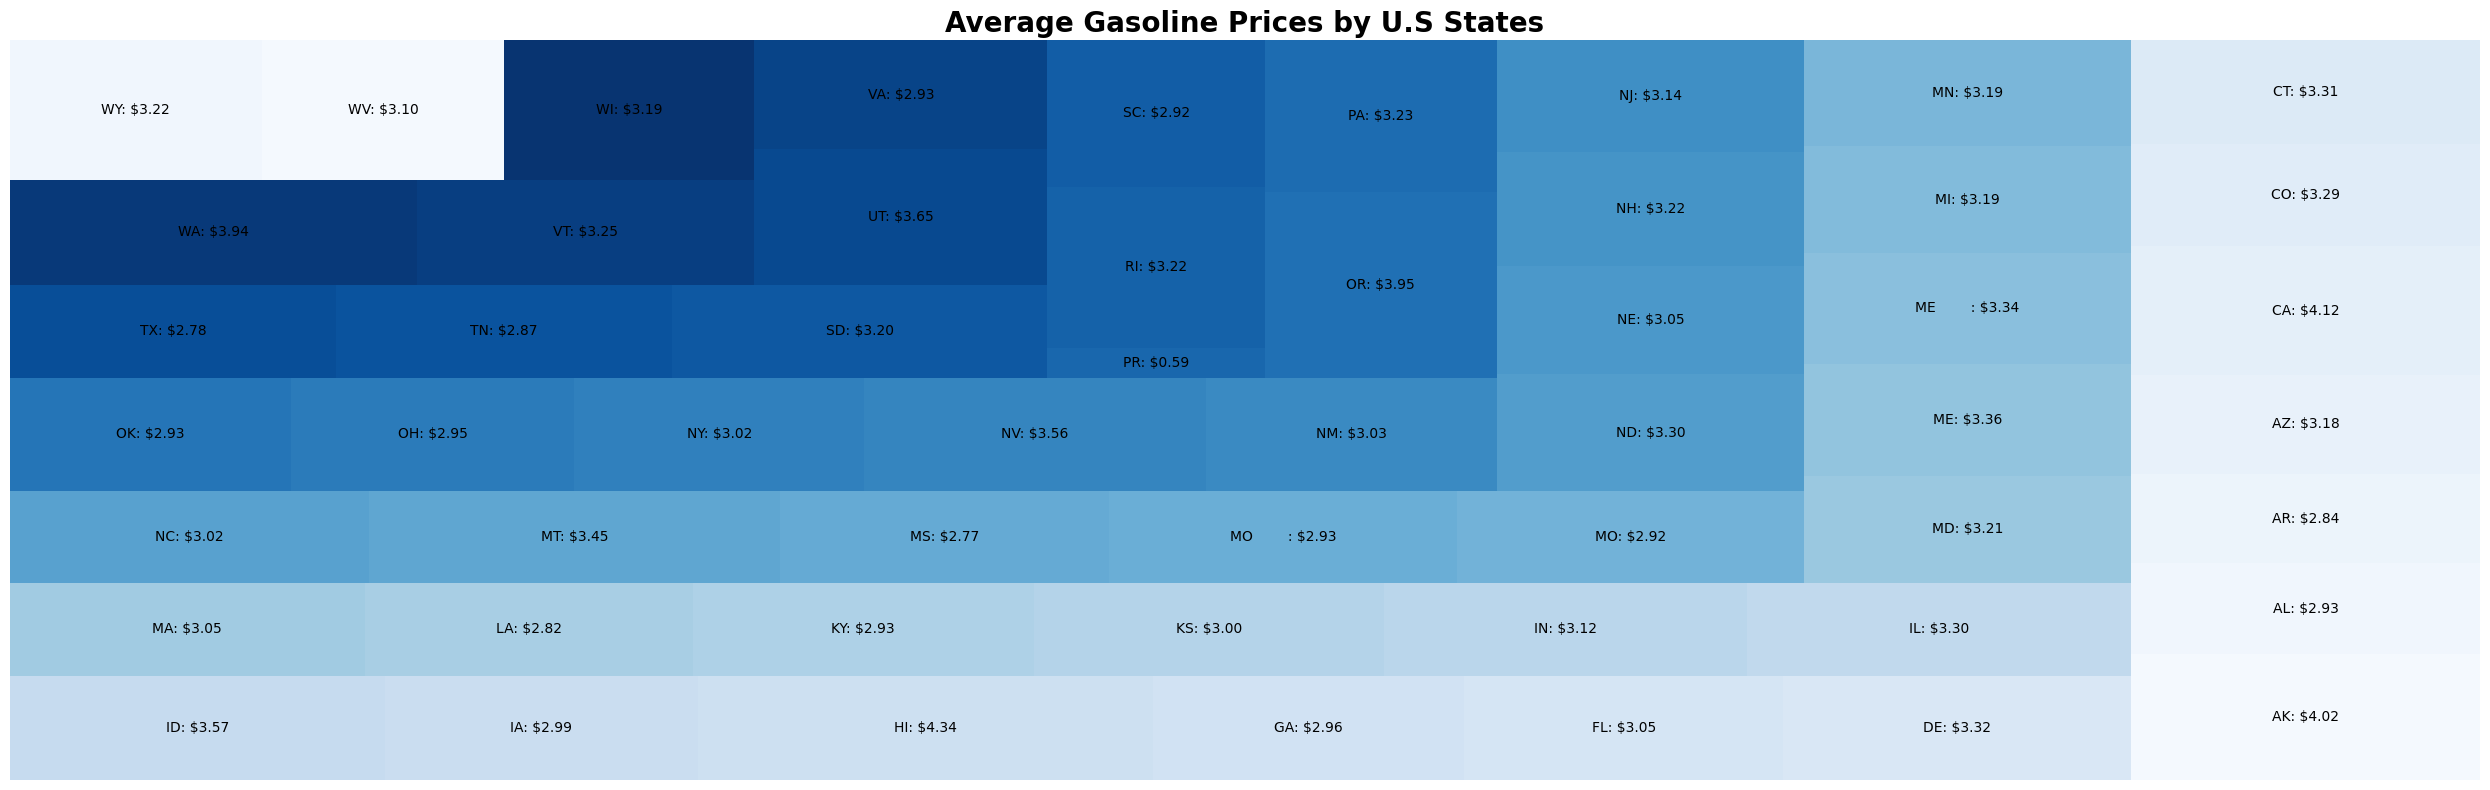

In [95]:
fig = plt.figure(figsize=(25,8))
ax = fig.add_subplot() 

sq.plot(sizes=list(avg_price), 
        label=[ f"{item[0]}: ${item[1]:.2f}" for item in zip(states, avg_price) ],
        ax=ax,
        color=sns.color_palette(palette='Blues', n_colors=51)
       )

ax.axis('off')
ax.invert_xaxis()
ax.set_title("Average Gasoline Prices by U.S States", fontweight='bold', fontsize=20)

plt.tight_layout() 